<div style="border:solid blue 2px; padding: 20px"> 

Задание  
Есть два датасета 1-7 ноября: Список
клиентов, которые зарегестрировались до 1 ноября, но сейчас пришли на продукт по SEO
источнику - Data_1 и тех, кто кто зарегестрировался с 1 по 7 ноября по SEO - Data_2


Необходимо ответить на вопросы:  
Характер поведения трафика с SEO источника   
Каков их клиентский путь    
Какие поддерживающие и продуктовые решения помогут нам улучшить процесс продуктово и маркетингово?  
Какие проблемы в клиенстком флоу мы видим сейчас?  

➔ FTD = first time depositor, важная метрика  
➔ reg = регистрация  
➔ STD = Событие внесение депозита второй раз за всю историю  
➔ Scorum = подраздел сайта с особыми типами игр  
    
1. [Шаг 1. Обзор данных. Откроем файл с данными и изучим общую информацию](#step1)  
2. [Шаг 2. Преобразование данных](#step2)  
    Разбил `user_pseudo_id` на 2 по разделителю точка на `id_1` и `id_2`  
    Добавил `f_t_visit` время первого визита  
    Добавил `delta` разница между событием и первым визитом в минутах  
    `rank` события пользователя по времени  
    Добавил год, неделю, день события
    
3. [Шаг 3. DAU, WAU.](#step3)  
 
4. [Шаг 4. Retention](#step4)  
  
5. [Шаг 5. Распределения времени и шага пользователя от первого визита до события](#step5) 
    
6. [Шаг 6. Время в днях между событиями  'ftd' и 'std'](#step6)  
    
7. [Шаг 7. Конверсия в действие.](#step7)  
    
8. [Шаг 8. Граф первых 5-действий пользователя.](#step8)      

</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from plotly import graph_objects as go 
from scipy import stats
import pylab

In [ ]:
from retentioneering.eventstream import Eventstream

### <a id="step1"></a>Шаг 1. Обзор данных.

In [2]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

In [3]:
data_1 = pd.read_csv('Data_1.csv')

In [4]:
data_2 = pd.read_csv('Data_2.csv')

In [5]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290257 entries, 0 to 2290256
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   event_name       object 
 1   event_timestamp  object 
 2   user_pseudo_id   float64
 3   page_url         object 
dtypes: float64(1), object(3)
memory usage: 69.9+ MB


In [6]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277739 entries, 0 to 277738
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       277739 non-null  int64  
 1   event_name       277739 non-null  object 
 2   event_timestamp  277739 non-null  object 
 3   user_pseudo_id   277739 non-null  float64
 4   page_url         275616 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 10.6+ MB


In [7]:
data_1.head()

event_name                 event_timestamp  user_pseudo_id page_url
0        reg  2023-11-03 07:56:02.880635 UTC    1.701402e+09      NaN
1        ftd  2023-11-03 17:40:03.069451 UTC    5.966870e+08      NaN
2        reg     2023-11-04 07:09:37.991 UTC    9.071352e+08      NaN
3        std  2023-11-02 15:32:38.050964 UTC    1.669020e+09      NaN
4        reg     2023-11-05 18:06:39.406 UTC    4.158711e+08      NaN

In [8]:
data_1.isna().sum()

event_name            0
event_timestamp       0
user_pseudo_id        0
page_url           1552
dtype: int64

In [9]:
data_2.head()

Unnamed: 0 event_name                   event_timestamp  user_pseudo_id  \
0           0  page_view  2023-11-24 22:53:23.422088+00:00    1.579584e+09   
1           1  page_view  2023-11-12 21:35:32.118060+00:00    1.537661e+09   
2           2  page_view  2023-11-13 02:32:15.188360+00:00    1.813921e+09   
3           3  page_view  2023-11-13 07:31:06.883108+00:00    1.690765e+09   
4           4  page_view  2023-11-25 09:11:29.495346+00:00    1.336548e+09   

                                            page_url  
0  https://www.pari.ru/sports/hockey/11781/43874260/  
1  https://www.pari.ru/mobile/live/hockey/46850/4...  
2  https://www.pari.ru/mobile/?affijet-click=6293...  
3  https://www.pari.ru/mobile/live/table-tennis/5...  
4  https://www.pari.ru/sports/basketball/13827/43...

In [10]:
data_2[data_2['Unnamed: 0'].isin([0,275615])] 

Unnamed: 0 event_name                   event_timestamp  \
0                0  page_view  2023-11-24 22:53:23.422088+00:00   
275615      275615  page_view  2023-11-05 11:35:13.985691+00:00   
275616           0        ftd  2023-11-03 16:43:56.536129+00:00   

        user_pseudo_id                                           page_url  
0         1.579584e+09  https://www.pari.ru/sports/hockey/11781/43874260/  
275615    4.698261e+08  https://www.pari.ru/mobile/profile/verificatio...  
275616    1.313632e+09                                                NaN

#### Дропаю столбец `Unnamed: 0` - считаю что это склейка 

In [11]:
data_2.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
data_2.isna().sum()

event_name            0
event_timestamp       0
user_pseudo_id        0
page_url           2123
dtype: int64

➔ FTD = first time depositor, важная метрика  
➔ reg = регистрация  
➔ STD = Событие внесение депозита второй раз за всю историю  
➔ Scorum = подраздел сайта с особыми типами игр  

### <a id="step2"></a>Шаг 2. Преобразование данных.

1. Разбил `user_pseudo_id` на 2 по разделителю точка на `id_1` и `id_2`  
2. Добавил `f_t_visit` время первого визита  
3. Добавил `delta` разница между событием и первым визитом в минутах
4. `rank` события пользователя по времени  
5. Добавил год, неделю, день события

In [13]:
def trans(df):

    df['user_pseudo_id'] = df['user_pseudo_id'].astype(str)
    
    df_temp = df['user_pseudo_id'].str.split('.', expand=True)
    
    df = pd.concat([df, df_temp], axis=1)
    
    df = df.rename(columns = {0: 'id_1', 1: 'id_2'})
    
    df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
    
    df = df.sort_values(by = ['user_pseudo_id','event_timestamp'], ascending = True)
    
    df['rank'] =  df.groupby('user_pseudo_id')['event_timestamp'].rank(method="first", ascending=True)
    
    df['f_t_visit'] =  df.groupby('user_pseudo_id')['event_timestamp'].transform('min')
    
    df['delta'] = df['event_timestamp'] - df['f_t_visit']
    
    df['delta'] = df['delta'].astype('timedelta64[m]')
    
    df.loc[(df['delta']==0) & (df['event_name']=='first_visit') ,'rank'] = 0.5
    
    df = df.sort_values(by = ['user_pseudo_id','rank'], ascending = True)
    
    df['rank1'] =  df.groupby('user_pseudo_id')['rank'].rank(method="first", ascending=True)
    
    df.drop(['rank'], axis=1, inplace=True)
    
    df = df.rename(columns = {'rank1': 'event_num'})
    
    df['year'] = df['event_timestamp'].dt.year
    df['week'] = df['event_timestamp'].dt.week
    df['day'] = df['event_timestamp'].dt.date
    
    return df.reset_index(drop = True)


### Преобразовываю `data_1`

In [14]:
%%time
d_1 = trans(data_1)

CPU times: total: 4min 6s
Wall time: 4min 14s


In [15]:
d_1.head()

event_name                  event_timestamp      user_pseudo_id  \
0  first_visit 2023-11-04 16:32:34.255988+00:00  1000080295.1699116   
1    page_view 2023-11-04 16:32:34.255988+00:00  1000080295.1699116   
2    page_view 2023-11-04 16:33:25.189729+00:00  1000080295.1699116   
3  first_visit 2023-11-04 20:00:17.125668+00:00  1000160510.1699128   
4    page_view 2023-11-04 20:00:17.125668+00:00  1000160510.1699128   

                              page_url        id_1     id_2  \
0  https://www.pari.ru/sports/esports/  1000080295  1699116   
1  https://www.pari.ru/sports/esports/  1000080295  1699116   
2          https://www.pari.ru/sports/  1000080295  1699116   
3                 https://www.pari.ru/  1000160510  1699128   
4                 https://www.pari.ru/  1000160510  1699128   

                         f_t_visit  delta  event_num  year  week         day  
0 2023-11-04 16:32:34.255988+00:00    0.0        1.0  2023    44  2023-11-04  
1 2023-11-04 16:32:34.255988+00:00    0.0        2.0  2023    44  2023-11-04  
2 2023-11-04 16:32:34.255988+00:00    0.0        3.0  2023    44  2023-11-04  
3 2023-11-04 20:00:17.125668+00:00    0.0        1.0  2023    44  2023-11-04  
4 2023-11-04 20:00:17.125668+00:00    0.0        2.0  2023    44  2023-11-04

In [16]:
d_1['user_pseudo_id'].nunique()

36182

In [17]:
d_1['id_1'].nunique()

36181

In [18]:
df_foo = d_1.groupby('id_1')[['id_2']].nunique().reset_index()

In [19]:
df_foo[df_foo['id_2'] > 1]

id_1  id_2
35125  94084410     2

у одного `id_1` два `id_2`, считаю что это один пользователь

### Преобразовываю `data_2`

In [20]:
%%time
d_2 = trans(data_2)

CPU times: total: 2.03 s
Wall time: 2.09 s


In [21]:
d_2.head()

event_name                  event_timestamp  \
0                    first_visit 2023-11-06 19:13:05.357635+00:00   
1                      page_view 2023-11-06 19:13:05.357635+00:00   
2            registration_button 2023-11-06 19:13:06.827326+00:00   
3                      page_view 2023-11-06 19:13:08.209871+00:00   
4  registration_form_field_phone 2023-11-06 19:13:13.616675+00:00   

       user_pseudo_id                                  page_url        id_1  \
0  1001718708.1699296                      https://www.pari.ru/  1001718708   
1  1001718708.1699296                      https://www.pari.ru/  1001718708   
2  1001718708.1699296                      https://www.pari.ru/  1001718708   
3  1001718708.1699296  https://www.pari.ru/account/registration  1001718708   
4  1001718708.1699296  https://www.pari.ru/account/registration  1001718708   

      id_2                        f_t_visit  delta  event_num  year  week  \
0  1699296 2023-11-06 19:13:05.357635+00:00    0.0        1.0  2023    45   
1  1699296 2023-11-06 19:13:05.357635+00:00    0.0        2.0  2023    45   
2  1699296 2023-11-06 19:13:05.357635+00:00    0.0        3.0  2023    45   
3  1699296 2023-11-06 19:13:05.357635+00:00    0.0        4.0  2023    45   
4  1699296 2023-11-06 19:13:05.357635+00:00    0.0        5.0  2023    45   

          day  
0  2023-11-06  
1  2023-11-06  
2  2023-11-06  
3  2023-11-06  
4  2023-11-06

In [22]:
d_2['user_pseudo_id'].nunique()

2527

In [23]:
d_2['id_1'].nunique()

2527

In [24]:
d_1.drop(['user_pseudo_id'], axis=1, inplace=True)

In [25]:
d_2.drop(['user_pseudo_id'], axis=1, inplace=True)

### <a id="step3"></a>Шаг 3. DAU, WAU.

In [26]:
def DAU(df, df_num):
    dau = df.groupby(['day']).agg({'id_1': 'nunique'}).reset_index()
    with plt.style.context('ggplot'):
        plt.subplots(figsize = (14,7))
        sns.barplot(x = 'day', y='id_1', data=dau)
        ax = plt.gca()
        ax.set_xlabel('Дата',fontsize=17)
        ax.tick_params(axis = 'x',  
                       labelsize = 13, labelrotation = 90)
        ax.tick_params(axis = 'y',  
                       labelsize = 14)
        plt.title(f'{df_num} - DAU',fontsize=23, y=1);
        plt.show();  

In [27]:
def WAU(df, df_num):
    wau = df.groupby(['week']).agg({'id_1': 'nunique'}).reset_index()
    with plt.style.context('ggplot'):
        plt.subplots(figsize = (14,7))
        sns.barplot(x = 'week', y='id_1', data=wau)
        ax = plt.gca()
        ax.set_xlabel('Дата',fontsize=17)
        ax.tick_params(axis = 'x',  
                       labelsize = 14, labelrotation = 0)
        ax.tick_params(axis = 'y',  
                       labelsize = 14)
        plt.title(f'{df_num} - WAU',fontsize=23, y=1);
        plt.show();

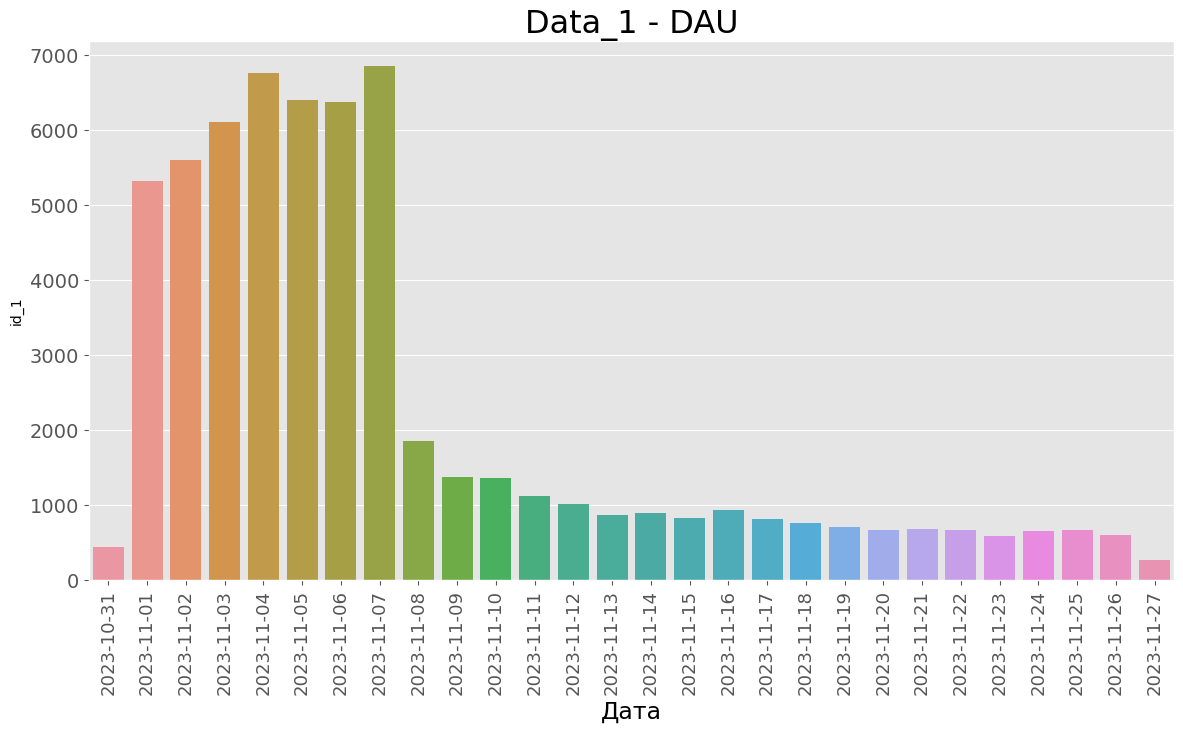

In [28]:
DAU(d_1, 'Data_1')

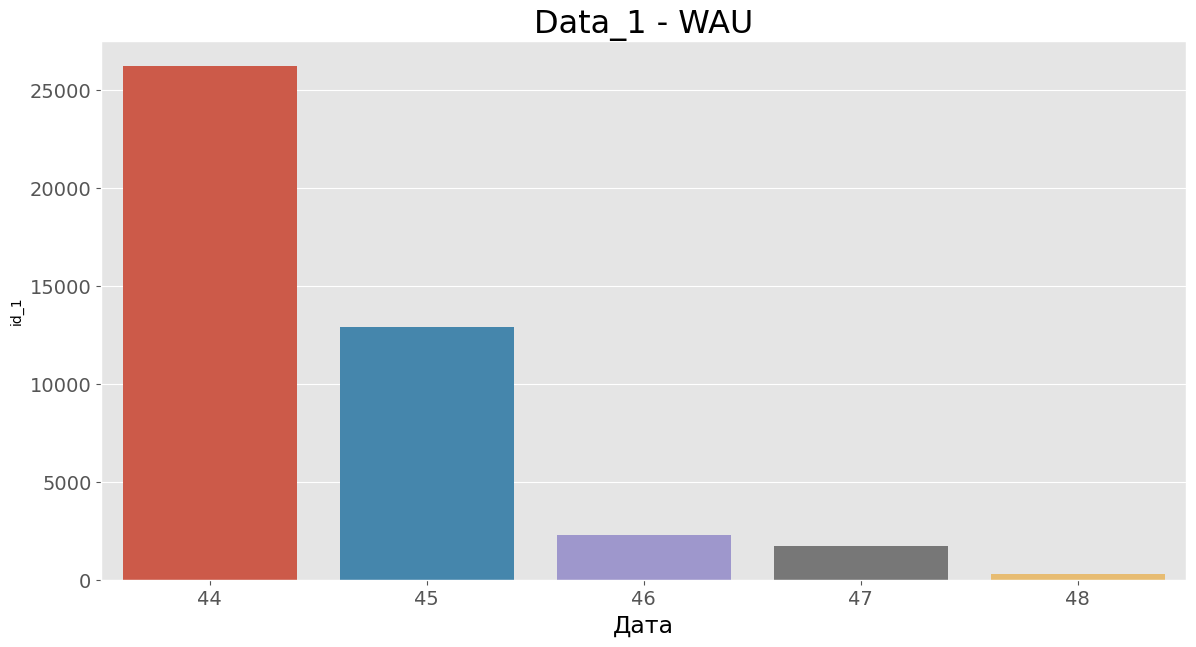

In [29]:
WAU(d_1, 'Data_1')

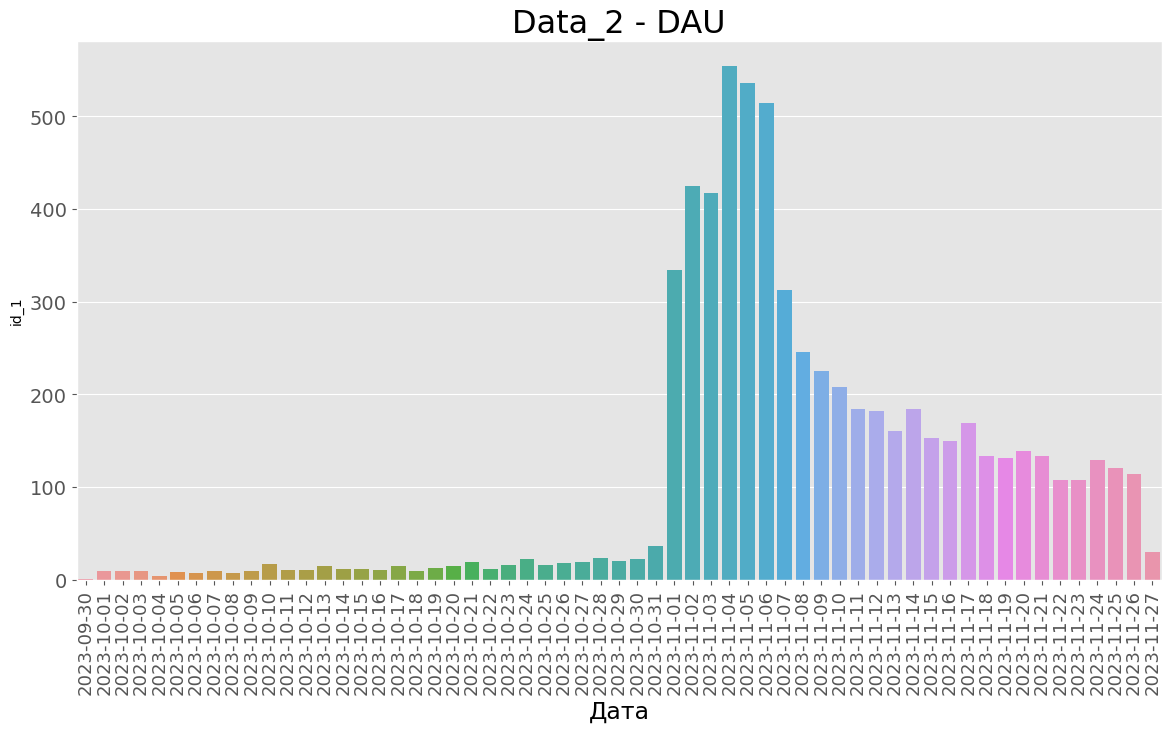

In [30]:
DAU(d_2, 'Data_2')

### Удалим данные до 1.11

In [31]:
d_2 = d_2[d_2['event_timestamp'] > '2023-11-01 00:00:00+00:00']
d_1 = d_1[d_1['event_timestamp'] > '2023-11-01 00:00:00+00:00']

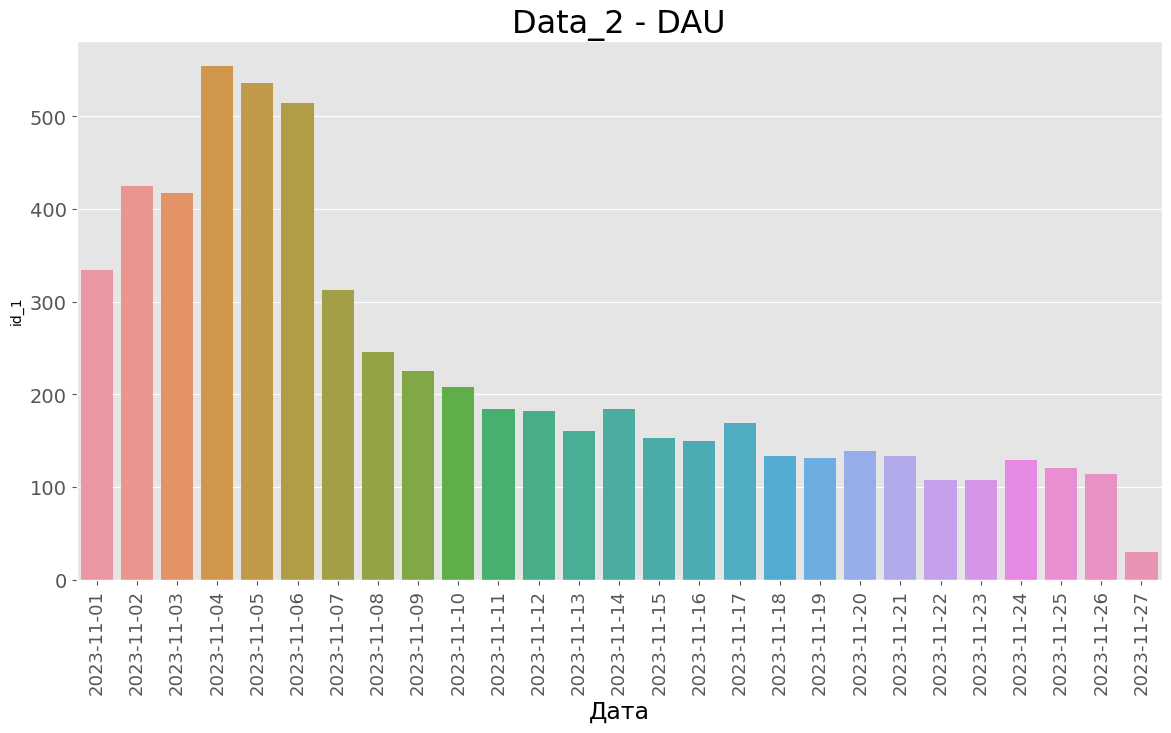

In [32]:
DAU(d_2, 'Data_2')

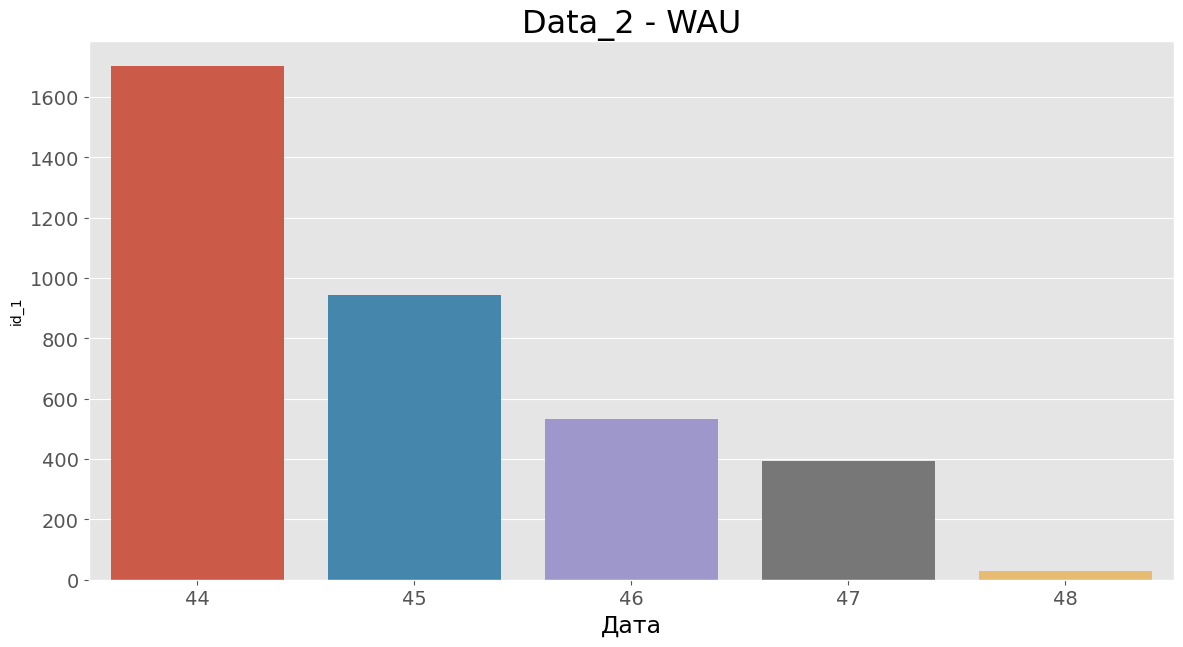

In [33]:
WAU(d_2, 'Data_2')

In [34]:
def first_visit(df, df_num):
    fv = df[df['event_name'] == 'first_visit']
    dau_fv = fv.groupby(['day']).agg({'id_1': 'nunique'}).reset_index()
    
    with plt.style.context('ggplot'):
        plt.subplots(figsize = (14,7))
        sns.barplot(x = 'day', y='id_1', data=dau_fv)
        ax = plt.gca()
        ax.set_xlabel('Дата',fontsize=17)
        ax.tick_params(axis = 'x',  
                       labelsize = 14, labelrotation = 90)
        ax.tick_params(axis = 'y',  
                       labelsize = 14)
        plt.title(f'{df_num} - First visit',fontsize=23, y=1)
        plt.show();

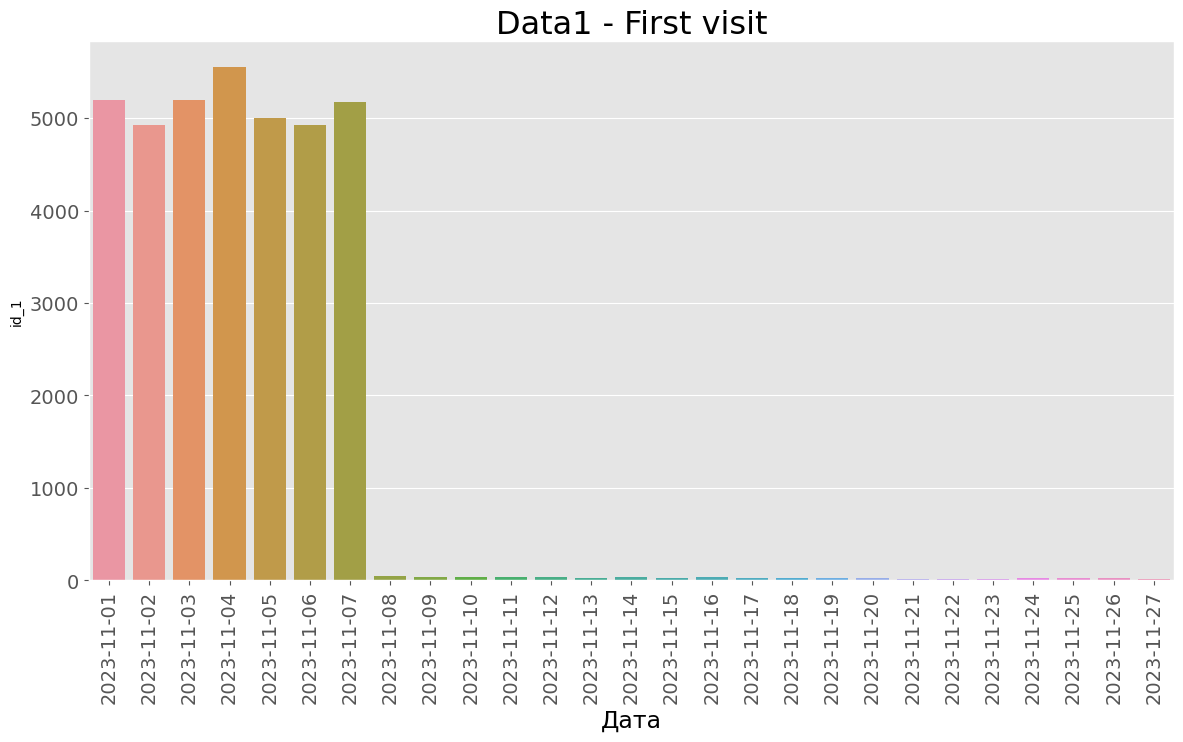

In [35]:
first_visit(d_1, 'Data1')

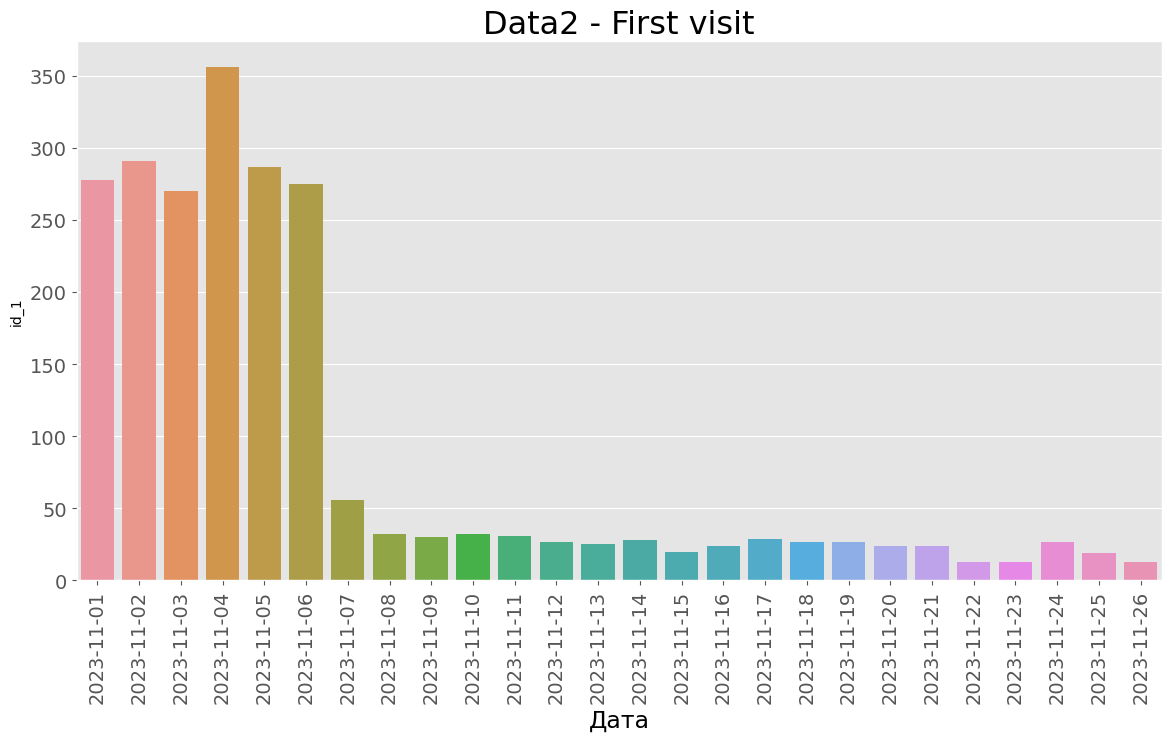

In [36]:
first_visit(d_2, 'Data2')

### <a id="step4"></a>Шаг 4. Retention rate

Рассчитаем `Retention rate`

In [37]:
def retention_piv(df):
    df['f_s_week'] = df['f_t_visit'].dt.week

    df['f_s_day'] = df['f_t_visit'].dt.date

    df['event_timestamp']= pd.to_datetime(df['event_timestamp'], unit='ns')

    df['cohort_lifetime'] = df['day'] - df['f_s_day']

    df['cohort_lifetime'] = df['cohort_lifetime'] / np.timedelta64(1,'D')

    df['cohort_lifetime'].unique()

    df['cohort_lifetime'] = df['cohort_lifetime'].round().astype('int')

    cohorts = df.groupby(['f_s_day','cohort_lifetime']).agg({'id_1':'nunique'}).reset_index()

    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['f_s_day','id_1']]
    initial_users_count = initial_users_count.rename(columns={'id_1':'cohort_users'})

    cohorts = cohorts.merge(initial_users_count,on='f_s_day')

    cohorts = cohorts[(cohorts['cohort_lifetime']>=0) & (cohorts['cohort_lifetime']<= 15) ]

    cohorts['retention'] = cohorts['id_1']/cohorts['cohort_users']

    retention_pivot = cohorts.pivot_table(index='f_s_day',
                                                              columns='cohort_lifetime',
                                                              values='retention',
                                                              aggfunc='sum')
    return retention_pivot

In [38]:
r_p_1 = retention_piv(d_1)

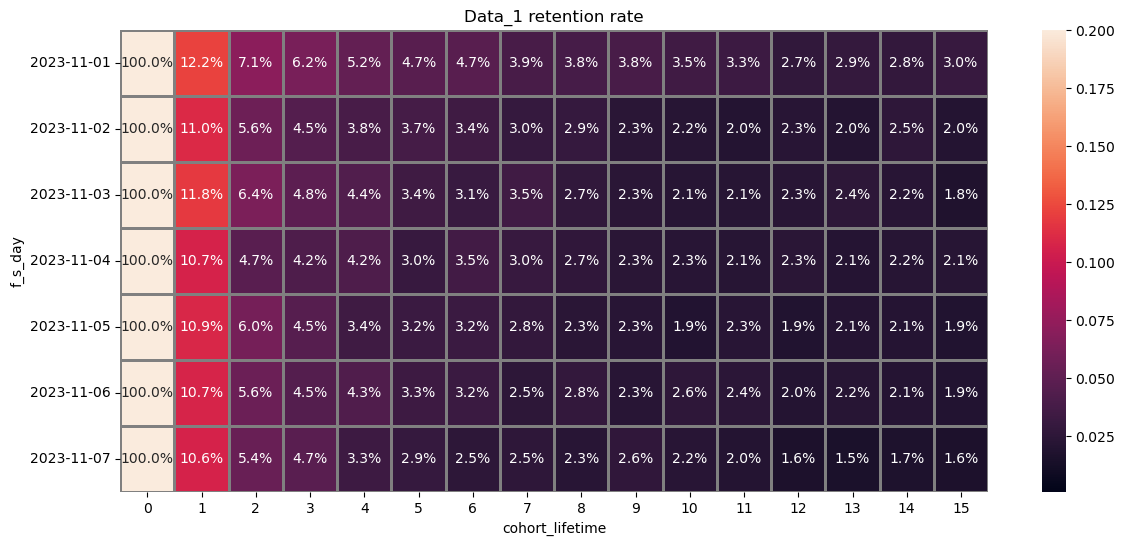

In [39]:
plt.figure(figsize=(14, 6))
plt.title('Data_1 retention rate')
sns.heatmap(r_p_1, vmin=0.001, vmax=0.2, annot=True, fmt='.1%', linewidths = 2, linecolor='gray');
# plt.yticks(rotation=0);
plt.show();

In [40]:
r_p_2 = retention_piv(d_2)

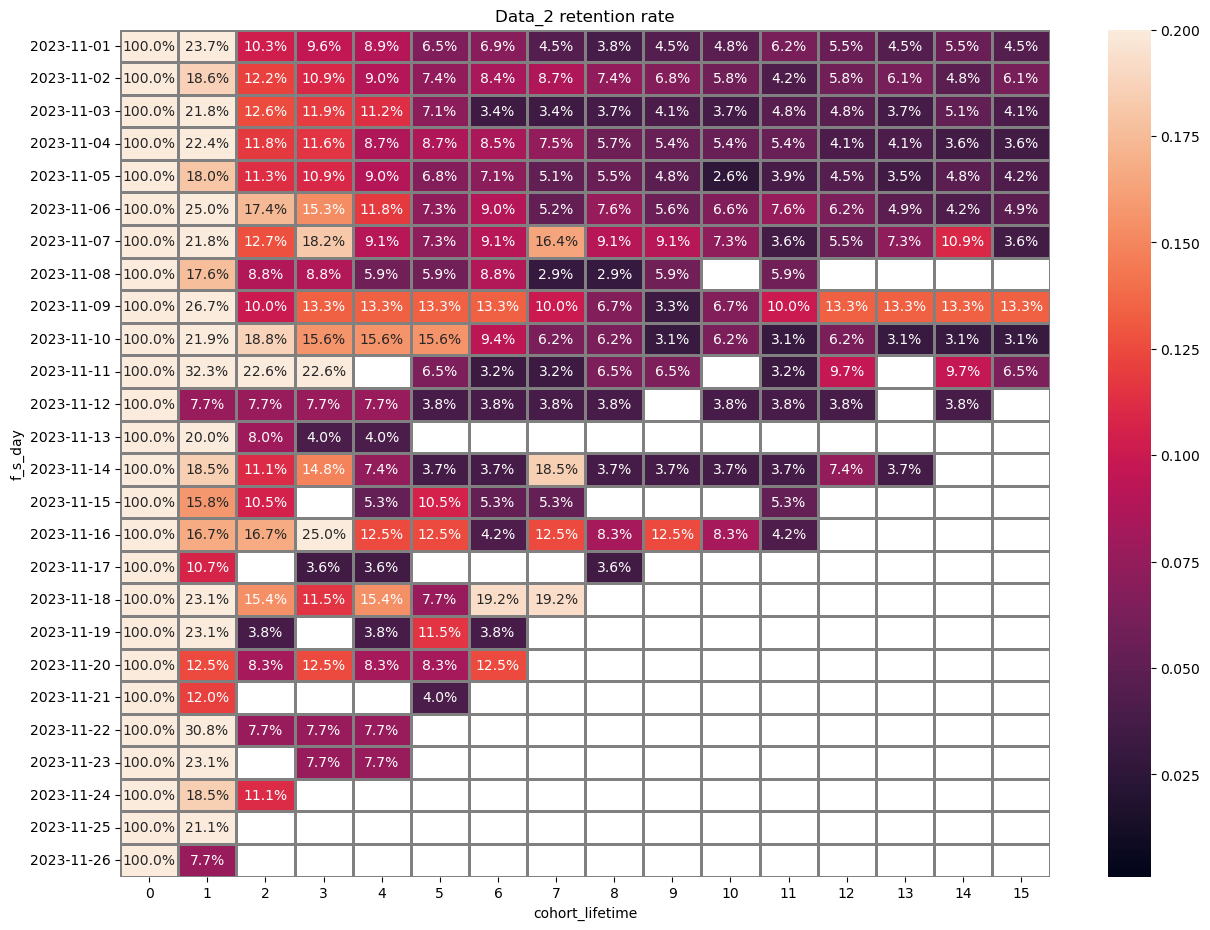

In [41]:
plt.figure(figsize=(15, 11))
plt.title('Data_2 retention rate')
sns.heatmap(r_p_2, vmin=0.001, vmax=0.2, annot=True, fmt='.1%', linewidths = 2, linecolor='gray');
# plt.yticks(rotation=0);
plt.show();

### Оставим тех пользователей , у которых первый визит был c 1 по 6 ноября 

In [42]:
d2_f = d_2[ ( d_2['event_timestamp'] >= '2023-11-01 00:00:00+00:00' ) & (d_2['event_timestamp'] <= '2023-11-08 00:00:00+00:00') &
             (d_2['event_name'] == 'first_visit') ]

In [43]:
d2_f_list = list(set(d2_f['id_1'].to_list()))

In [44]:
d_2_m = d_2[d_2['id_1'].isin(d2_f_list)]

In [45]:
r_p_2 = retention_piv(d_2_m)

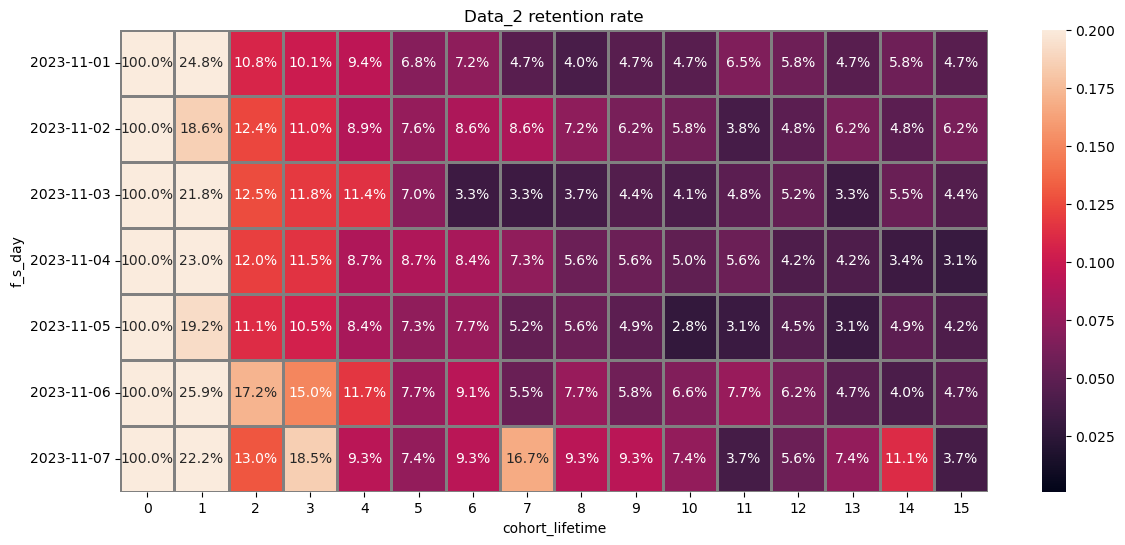

In [46]:
plt.figure(figsize=(14, 6))
plt.title('Data_2 retention rate')
sns.heatmap(r_p_2, vmin=0.001, vmax=0.2, annot=True, fmt='.1%', linewidths = 2, linecolor='gray');
plt.yticks(rotation=0);
plt.show();

## <a id="step5"></a>Шаг 5. Распределения времени и шага пользователя от первого визита до события

### До регистрации `reg`

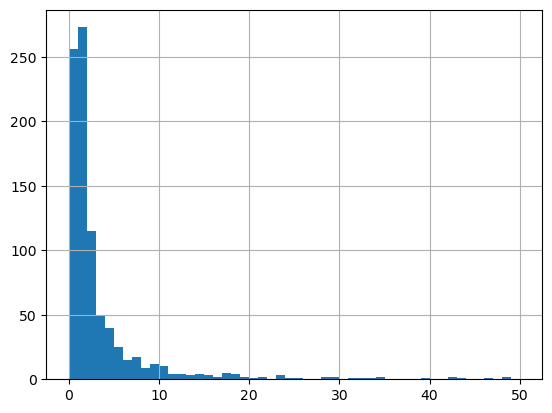

In [47]:
d_1[d_1['event_name']=='reg']['delta'].hist(bins=50, range = (0,50))
plt.show();

In [48]:
d_1[d_1['event_name']=='reg']['delta'].describe()

count     1019.000000
mean       925.068695
std       4083.498360
min          0.000000
25%          0.000000
50%          1.000000
75%          6.000000
max      35711.000000
Name: delta, dtype: float64

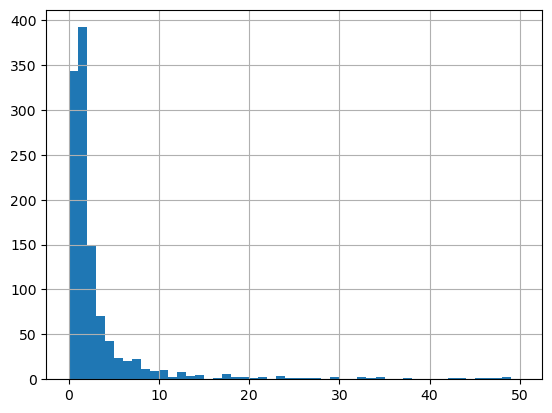

In [49]:
d_2[d_2['event_name']=='reg']['delta'].hist(bins=50, range = (0,50))
plt.show();

In [50]:
d_1[d_1['event_name']=='reg']['delta'].describe()

count     1019.000000
mean       925.068695
std       4083.498360
min          0.000000
25%          0.000000
50%          1.000000
75%          6.000000
max      35711.000000
Name: delta, dtype: float64

<div style="border:solid blue 2px; padding: 20px">
У первого и второго датасета медианное значение времени перехода на событие `reg`одинаково - 1 минута
</div>

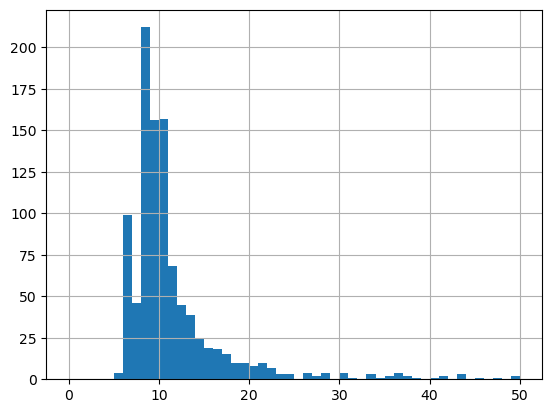

In [51]:
d_1[d_1['event_name']=='reg']['event_num'].hist(bins=50, range = (0,50))
plt.show();

In [52]:
d_1[d_1['event_name']=='reg']['event_num'].describe()

count    1019.000000
mean       17.147203
std        78.340223
min         5.000000
25%         8.000000
50%         9.000000
75%        12.000000
max      2235.000000
Name: event_num, dtype: float64

In [53]:
d_2[d_2['event_name']=='reg']['event_num'].describe()

count    1328.000000
mean       36.569277
std       281.400721
min         5.000000
25%         8.000000
50%         9.000000
75%        11.000000
max      5483.000000
Name: event_num, dtype: float64

<div style="border:solid blue 2px; padding: 20px">
У первого и второго датасета медианное значение шага перехода на событие `reg`одинаково - 9
</div>

### До `ftd` - first time depositor

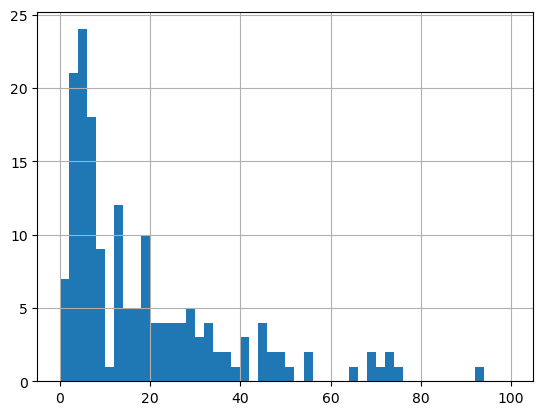

In [54]:
d_1[d_1['event_name']=='ftd']['delta'].hist(bins=50, range = (0,100))
plt.show();

In [55]:
d_1[d_1['event_name']=='ftd']['delta'].describe()

count      316.000000
mean      3750.408228
std       7561.600216
min          1.000000
25%         10.500000
50%         54.500000
75%       3017.000000
max      34057.000000
Name: delta, dtype: float64

In [56]:
d_2[d_2['event_name']=='ftd']['delta'].describe()

count      437.000000
mean      5467.867277
std      11461.608991
min          1.000000
25%         12.000000
50%        103.000000
75%       4469.000000
max      65867.000000
Name: delta, dtype: float64

<div style="border:solid blue 2px; padding: 20px">
Медианное значение времени перехода на событие `ftd`   
    1 - 54 мин  
    2 - 103 мин
</div>

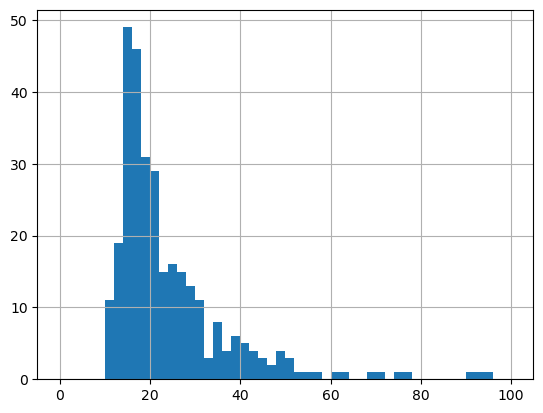

In [57]:
d_1[d_1['event_name']=='ftd']['event_num'].hist(bins=50, range = (0,100))
plt.show();

In [58]:
d_1[d_1['event_name']=='ftd']['event_num'].describe()

count     316.000000
mean       34.803797
std       131.799846
min        10.000000
25%        15.750000
50%        20.000000
75%        29.000000
max      2254.000000
Name: event_num, dtype: float64

In [59]:
d_2[d_2['event_name']=='ftd']['event_num'].describe()

count     437.000000
mean       64.407323
std       313.272932
min         9.000000
25%        15.000000
50%        20.000000
75%        29.000000
max      5105.000000
Name: event_num, dtype: float64

<div style="border:solid blue 2px; padding: 20px">
Медианное шаго перехода на событие `ftd`   
    1 - 20  
    2 - 20
</div>

### До `std` - second time depositor

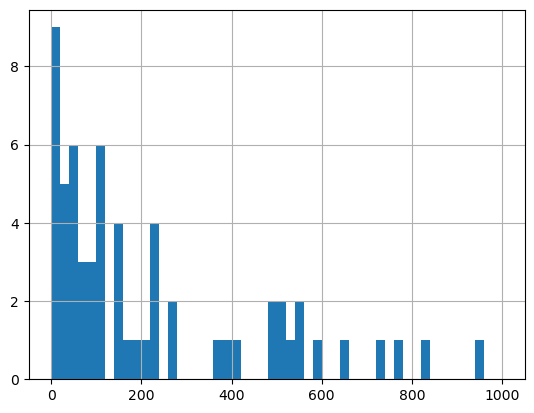

In [60]:
d_1[d_1['event_name']=='std']['delta'].hist(bins=50, range = (0,1000))
plt.show();

In [61]:
d_1[d_1['event_name']=='std']['delta'].describe()

count      206.000000
mean      6988.956311
std       9077.659145
min          2.000000
25%        517.250000
50%       2708.000000
75%       9528.500000
max      34730.000000
Name: delta, dtype: float64

In [62]:
d_2[d_2['event_name']=='std']['delta'].describe()

count      291.000000
mean      9923.800687
std      13286.630506
min          2.000000
25%       1164.500000
50%       4364.000000
75%      13696.000000
max      70161.000000
Name: delta, dtype: float64

<div style="border:solid blue 2px; padding: 20px">
Медианное значение времени перехода на событие `std`   
    1 - 1.8 дня  
    2 - 2 дня
</div>

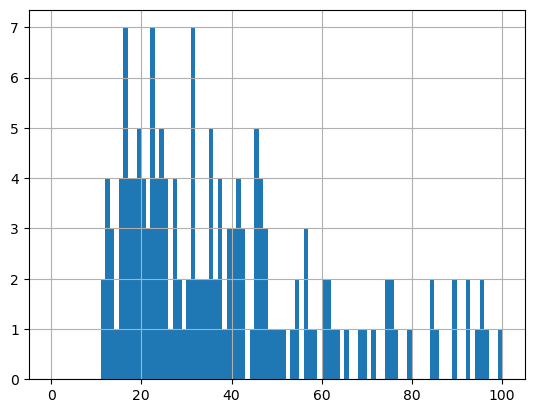

In [63]:
d_1[d_1['event_name']=='std']['event_num'].hist(bins=100, range = (0,100))
plt.show();

In [64]:
d_1[d_1['event_name']=='std']['event_num'].describe()

count     206.000000
mean       91.800971
std       208.958706
min        11.000000
25%        23.250000
50%        41.000000
75%        89.000000
max      2255.000000
Name: event_num, dtype: float64

In [65]:
d_2[d_2['event_name']=='std']['event_num'].describe()

count     291.000000
mean      127.817869
std       427.441931
min        10.000000
25%        22.000000
50%        38.000000
75%        77.500000
max      5869.000000
Name: event_num, dtype: float64

<div style="border:solid blue 2px; padding: 20px">
Медианное шаго перехода на событие `std`   
    1 - 41  
    2 - 38
   
</div>

### До `scorum_link_button_click`

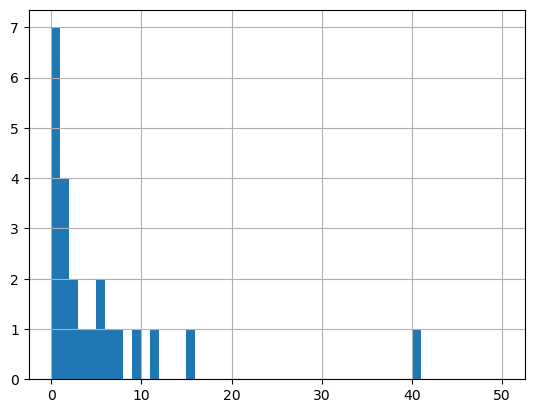

In [66]:
d_1[d_1['event_name']=='scorum_link_button_click']['delta'].hist(bins=50, range = (0,50))
plt.show();

In [67]:
d_1[d_1['event_name']=='scorum_link_button_click']['delta'].describe()

count       46.000000
mean      3620.847826
std       7242.621563
min          0.000000
25%          2.000000
50%         49.500000
75%       1677.250000
max      30744.000000
Name: delta, dtype: float64

In [68]:
d_2[d_2['event_name']=='scorum_link_button_click']['delta'].describe()

count      1.0
mean     734.0
std        NaN
min      734.0
25%      734.0
50%      734.0
75%      734.0
max      734.0
Name: delta, dtype: float64

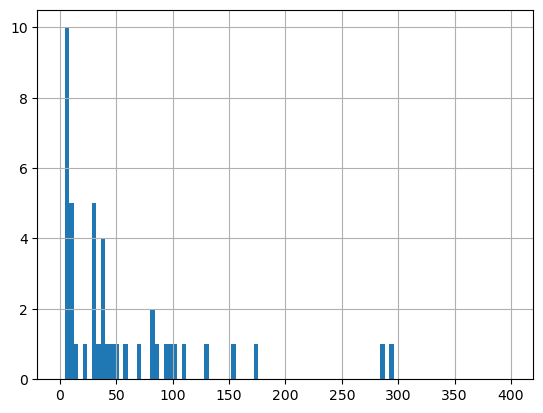

In [69]:
d_1[d_1['event_name']=='scorum_link_button_click']['event_num'].hist(bins=100, range = (0,400))
plt.show();

In [70]:
d_1[d_1['event_name']=='scorum_link_button_click']['event_num'].describe()

count      46.000000
mean       92.173913
std       197.809370
min         4.000000
25%        10.000000
50%        35.000000
75%        85.250000
max      1185.000000
Name: event_num, dtype: float64

In [71]:
d_2[d_2['event_name']=='scorum_link_button_click']['event_num'].describe()

count     1.0
mean     15.0
std       NaN
min      15.0
25%      15.0
50%      15.0
75%      15.0
max      15.0
Name: event_num, dtype: float64

## <a id="step6"></a>Шаг 6. Расчет времени в днях между событиями  'ftd' и 'std'

In [72]:
def ftd_std_days(df):
    df_pv = df[df['event_name'].isin(['ftd', 'std'])].reset_index(drop = True)

    df_pv = df_pv.sort_values(by = ['id_1','event_name'], ascending = True)

    df_pv['min'] = df_pv.groupby('id_1')['event_timestamp'].transform('min')

    std_list = list(set(df_pv[df_pv['event_name'] =='std']['id_1'].to_list()))

    df_pv = df_pv[df_pv['id_1'].isin(std_list)]

    df_pv['delta'] = df_pv['event_timestamp'] - df_pv['min']

    df_pv = df_pv[['event_name', 'event_timestamp', 'id_1', 'min','delta']] 

    df_pv['delta_1'] = df_pv['delta'].astype('timedelta64[m]')

    df_pv['delta_1'] = (df_pv['delta_1'] / (60 * 24)).round(2)

    df_pv  = df_pv[df_pv['delta_1'] != 0 ].reset_index(drop = True)
    return df_pv

In [73]:
df_pv_d_1 = ftd_std_days(d_1)

In [74]:
df_pv_d_2 = ftd_std_days(d_2)

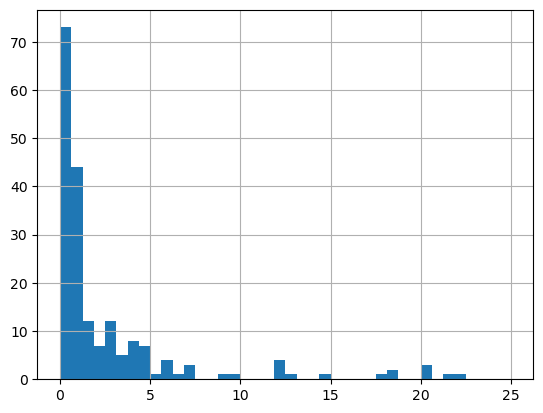

In [75]:
df_pv_d_1['delta_1'].hist(bins=40, range = (0,25))
plt.show();

In [76]:
df_pv_d_1['delta_1'].describe()

count    193.000000
mean       2.663005
std        4.489612
min        0.010000
25%        0.150000
50%        0.970000
75%        3.050000
max       22.130000
Name: delta_1, dtype: float64

In [77]:
df_pv_d_2['delta_1'].describe()

count    284.000000
mean       3.295704
std        4.769549
min        0.010000
25%        0.207500
50%        1.165000
75%        3.942500
max       22.130000
Name: delta_1, dtype: float64

<div style="border:solid blue 2px; padding: 20px">
Медианное время между событиями 'ftd' и `std`   
    1 - 1 день    
    2 - 1.16 дня  
</div>

## <a id="step7"></a>Шаг 7. Конверсия в действие.

По условию нет последовательности событий, 
Сделал цепочку:  
`reg`→ `ftd` → `std` → `scorum`   
все остальные события я объединил и назвал `any`.   

In [78]:
def funnel_event(df):
    df.loc[(df['event_name'] == 'scorum_link_button_click') , 'event_name'] = 'scorum'

    df['event_name_1'] = df['event_name']

    df.loc[((df['event_name']!='reg') & (df['event_name'] != 'page_view') & (df['event_name'] != 'first_visit')
            & (df['event_name'] != 'scorum')&
             (df['event_name'] != 'ftd')&(df['event_name'] != 'std')), 'event_name_1'] = 'any'

    logs_EventU = df.groupby('event_name_1', as_index=False).agg({'id_1': 'nunique'})
    logs_EventU = logs_EventU.sort_values(by = 'id_1', ascending = False).reset_index(drop=True)

    logs_EventU['%'] = ((logs_EventU['id_1'] / logs_EventU['id_1'].sum())*100).round(2)

    logs_EventU['Shift'] = logs_EventU['id_1'].shift(1)

    logs_EventU.loc[logs_EventU['Shift'].isna(), 'Shift'] = logs_EventU['id_1']


    logs_EventU['% Previous'] = ((logs_EventU['id_1']/logs_EventU['Shift'])*100).round(2)

    logs_EventU['% of initial'] = ((logs_EventU['id_1']/logs_EventU['id_1'][0])*100).round(2)
    
    return logs_EventU

In [79]:
Funnel_d_1 = funnel_event(d_1)

In [80]:
fig = go.Figure(go.Funnel( hoverinfo = "skip",
    y = Funnel_d_1['event_name_1'],
    x = Funnel_d_1['id_1'],
     textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.show() 

In [81]:
Funnel_d_2 = funnel_event(d_2)

In [82]:
fig = go.Figure(go.Funnel( hoverinfo = "skip",
    y = Funnel_d_2['event_name_1'],
    x = Funnel_d_2['id_1'],
     textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )
fig.show() 

## <a id="step8"></a>Шаг 8. Граф первых 5 действий пользователя.

In [83]:
def graph(df):
    gr_df = df[(df['event_num']>=1)&(df['event_num']<=5)]

    gr_df = gr_df[['id_1','event_name','event_timestamp']]

    gr_df = gr_df.rename(columns = {'id_1': 'user_id', 'event_name': 'event', 'event_timestamp': 'timestamp'})
    return gr_df

In [84]:
gr_1 = graph(d_1)

In [85]:
gr_2 = graph(d_2)

In [86]:
stream_1 = Eventstream(gr_1)

In [87]:
stream_2 = Eventstream(gr_2)

In [88]:
stream_1.to_dataframe()

In [89]:
stream_2.to_dataframe()

In [90]:
stream_1.transition_graph()

In [91]:
stream_2.transition_graph()